# FW and PGD Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils.extmath import randomized_svd as rsvd

In [2]:
def solve_constrain(s):
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    return np.maximum(s-theta, 0)
    

def nuclear_projection(A):
    # Using Truncated SVD
    m = A.shape[0]
    n = A.shape[1]
    k = 1
    while True:
        if (k>=m):
            u,s,v = rsvd(A, n_components=m)
            break
        u,s,v = rsvd(A, n_components=k)
        
        if (np.sum(s)<=1 and np.alltrue(s >= 0)):
            k = 2*k
            continue
        else:
            s = solve_constrain(s)
            break
    s.resize(m)
    U = np.zeros((m,m))
    V = np.zeros((n,n))
    U[:u.shape[0],:u.shape[1]]=u
    V[:v.shape[0],:v.shape[1]]=v
    return U.dot(np.diag(s).dot(V))
    
def convergence_plot(A,Xfw,Xp,obj,prim):
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title('Convergence in objective')    
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale('log')
    fs1 = [obj(X) for X in Xfw]
    fs2 = [obj(X) for X in Xp]
    plt.plot(range(len(fs1)), fs1, label='Frank-Wolfe')
    plt.plot(range(len(fs2)), fs2, label='Projected-GD')    
    plt.legend()
    
    plt.subplot(122)
    plt.title('Convergence in domain')    
    plt.xlabel('Step')
    plt.yscale('log')
    gs1 = [prim(X) for X in Xfw]
    gs2 = [prim(X) for X in Xp]
    plt.plot(range(len(gs1)), gs1, label='Frank-Wolfe')
    plt.plot(range(len(gs2)), gs2, label='Projected-GD')  
    plt.legend()
    plt.tight_layout()
    

def projected_gd(init, step, grad, obj, epi, proj=lambda x: x):
    xs = [init]
    ys = obj(xs[-1])
    yo = ys.copy()
    start = time.perf_counter()
    time_flag = True
    while True:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
        ys = obj(xs[-1])
        if (np.abs(ys-yo) < epi):
            break
        yo = ys.copy()
        if(time_flag and yo<1e-4):
            print('PGD Time elasped to 1e-4 Error:',time.perf_counter()-start)
            time_flag = False
    return xs

def mc_objective(Y, O, X):

    return 0.5 * np.linalg.norm(Y-np.multiply(X, O), 'fro')**2

def mc_gradient(Y, O, X):

    return np.multiply(X, O) - Y

def frank_wolfe(init, oracle, grad, obj, prim, epi, back_tracking=False):
    xs = [init]
    ys = prim(xs[-1])
    yo = ys.copy()
    start = time.perf_counter()
    time_flag = True
    while True:
        yobj = obj(xs[-1])
        if back_tracking:
            beta = 0.8
            step = 1
            gs = grad(xs[-1])
            os = oracle(xs[-1])-xs[-1]
            dx = np.trace(gs.T.dot(os))
            while (obj(xs[-1]+step*os) > yobj+0.5*step*dx):
                step = beta*step
        else:
            step = 2./(len(xs)+1.)
        xs.append(xs[-1] + step*(oracle(xs[-1])-xs[-1]))
        ys = prim(xs[-1])
        if (np.abs(ys-yo) < epi):
            break
        yo = ys.copy()
        if(time_flag and yobj<1e-4):
            print('FW Time elasped to 1e-4 Error:',time.perf_counter()-start)
            time_flag = False
    return xs

def mc_oracle(Y, O, X):

    G = mc_gradient(Y, O, X)
    x, _, y = rsvd(-G,n_components=1)
    x = x[:,0]
    y = y[0]
    return x.reshape((len(x), 1)).dot(y.reshape((1,len(y))))

# Experiment Setup

We start from random matrix of nuclear norm 1. For simplification, we also set the nuclear norm constraint trace(X)<=1.

In [3]:
def FW_vs_PGD(n,k,bt=False,pgd_lr=0.2):
    # n, k = 500, 15
    U = np.random.normal(0, 1, (n, k))
    U = np.linalg.qr(U)[0]
    S = np.diag(np.random.uniform(0, 1, k))
    S /= np.sum(S)
    A = U.dot(S.dot(U.T))
    O = np.random.randint(0,2, (n, n))
    Y = np.multiply(A, O)
    epi = 1e-10
    X0 = np.random.normal(0,1, (n,n))
    X0 = nuclear_projection(X0.dot(X0.T))

    objective = lambda X: mc_objective(Y, O, X)
    gradient = lambda X: mc_gradient(Y, O, X)
    oracle = lambda X: mc_oracle(Y, O, X)
    prim = lambda X: np.linalg.norm(A-X, 'fro')**2 

    Xfw = frank_wolfe(X0.copy(), oracle, gradient, objective, prim, epi, back_tracking=bt)
    Xp = projected_gd(X0.copy(), pgd_lr, gradient, objective, epi, nuclear_projection)
    convergence_plot(A,Xfw,Xp,objective,prim)

    _,S_opt,_ = rsvd(A,n_components=25)
    _,Sfw,_ = rsvd(Xfw[-1],n_components=25)
    _,Sp,_ = rsvd(Xp[-1],n_components=25)

    plt.figure(figsize=(14,6))
    plt.title('Largest 20 singular values of recovered solution')
    plt.plot(range(20), np.sort(Sfw)[::-1][:20], 'o-', label='recovered(Frank-Wolfe)')
    plt.plot(range(20), np.sort(Sp)[::-1][:20], 'o-', label='recovered(Projected-GD)')
    plt.plot(range(20), np.sort(S_opt)[::-1][:20], 'o-', label='optimal')
    plt.legend()


# Result
We will investigate several properties in the following part:

* Sanity: Are FW and PGD reaching the same solution?
* How does step size affect?
* How does data size affect?

We plot three figures for every experiment setting: 
* Learning curve in objective function using FW/PGD
* Difference between groundtruth and our FW/PGD result under Forbenius norm during training
* Largest 20 singular values of the converged result of FW/PGD comparing with the grouondtruth

FW Time elasped to 1e-4 Error: 0.23720920299820136
PGD Time elasped to 1e-4 Error: 0.6803063279949129


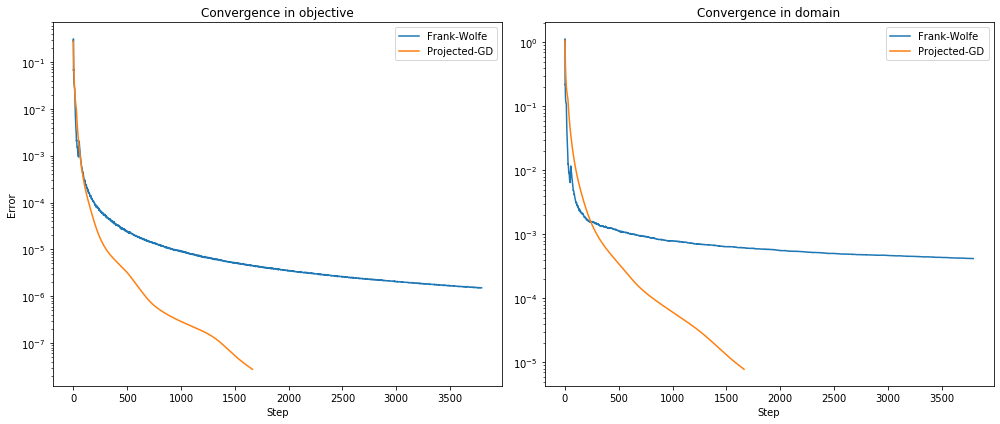

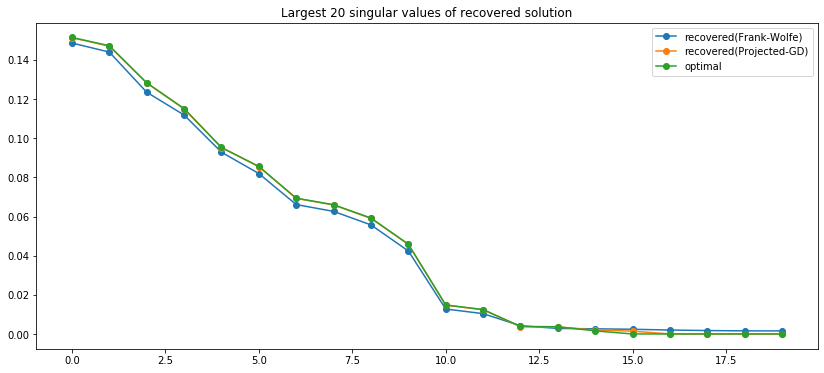

In [4]:
FW_vs_PGD(100,15,bt=False,pgd_lr=0.2)

FW Time elasped to 1e-4 Error: 0.5563600570021663
PGD Time elasped to 1e-4 Error: 2.064186427000095


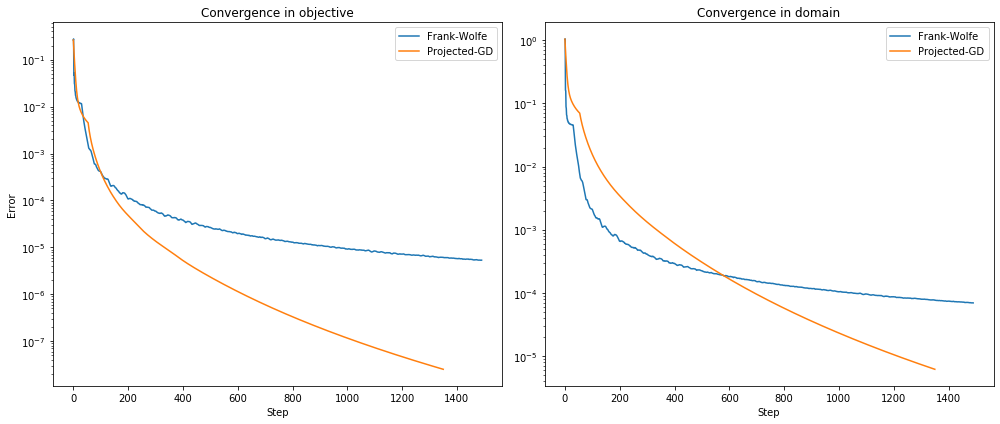

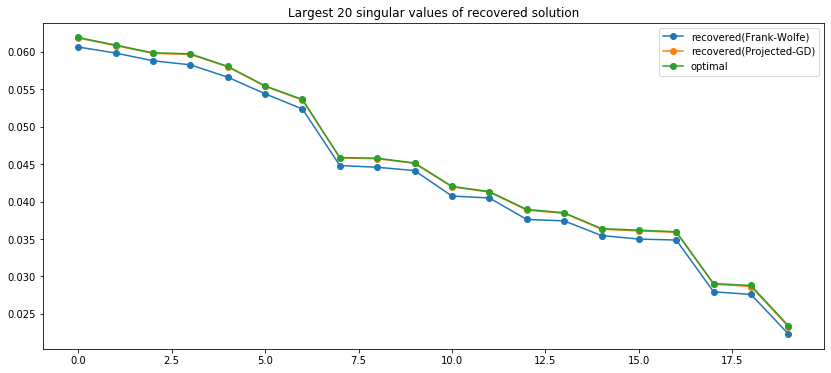

In [5]:
FW_vs_PGD(300,30,bt=False,pgd_lr=0.2)

FW Time elasped to 1e-4 Error: 0.8226528329978464
PGD Time elasped to 1e-4 Error: 1.9260636510007316


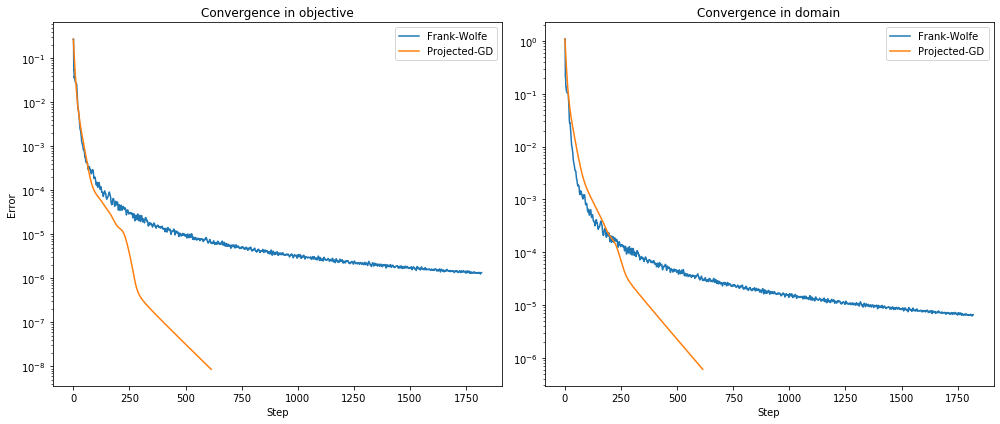

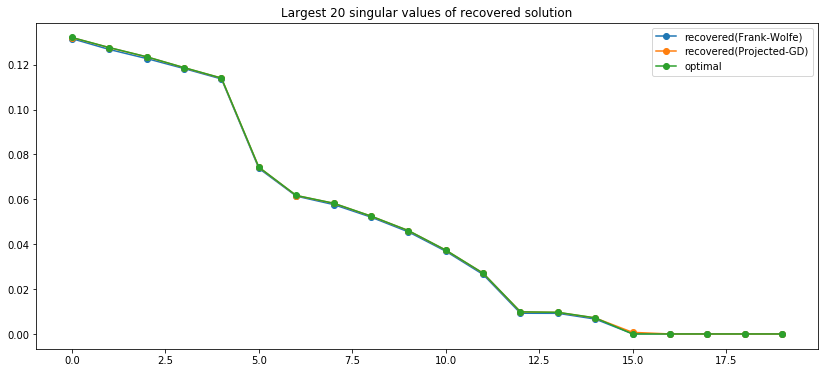

In [4]:
FW_vs_PGD(600,15,bt=False,pgd_lr=0.2)

FW Time elasped to 1e-4 Error: 1.9443616330026998
PGD Time elasped to 1e-4 Error: 1.2695110659988131


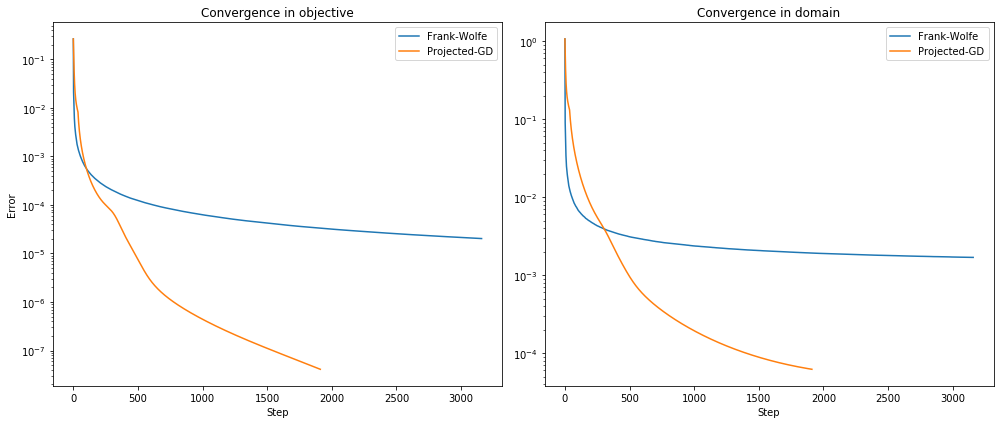

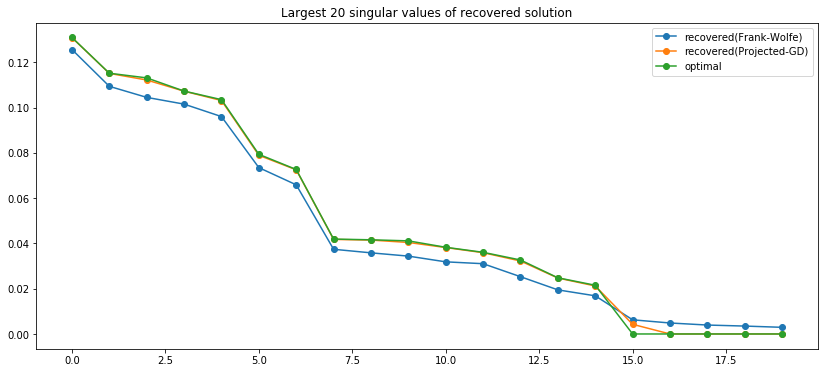

In [6]:
FW_vs_PGD(100,15,bt=True,pgd_lr=0.2)

FW Time elasped to 1e-4 Error: 9.681097654996847
PGD Time elasped to 1e-4 Error: 1.8830601130030118


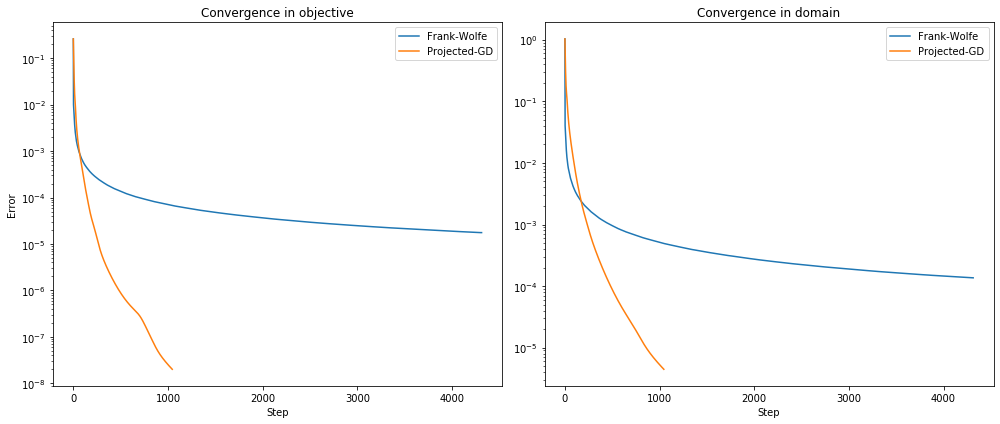

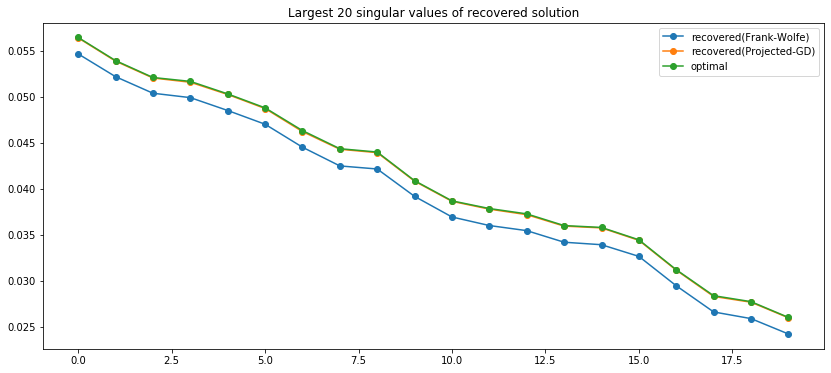

In [7]:
FW_vs_PGD(300,30,bt=True,pgd_lr=0.2)

FW Time elasped to 1e-4 Error: 0.2606546629976947
PGD Time elasped to 1e-4 Error: 0.5833841499988921


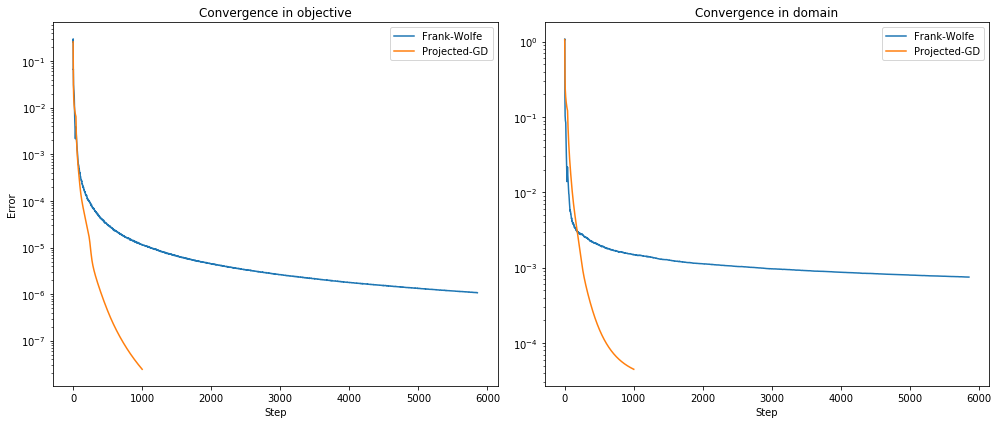

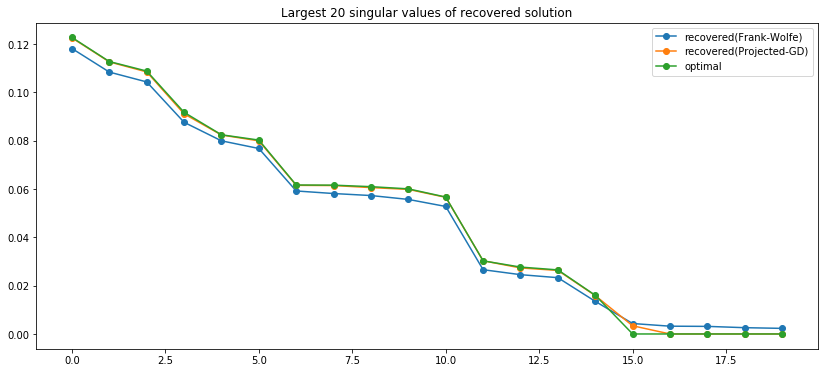

In [8]:
FW_vs_PGD(100,15,bt=False,pgd_lr=0.4)

FW Time elasped to 1e-4 Error: 0.22142109699780121
PGD Time elasped to 1e-4 Error: 0.36668660599389113


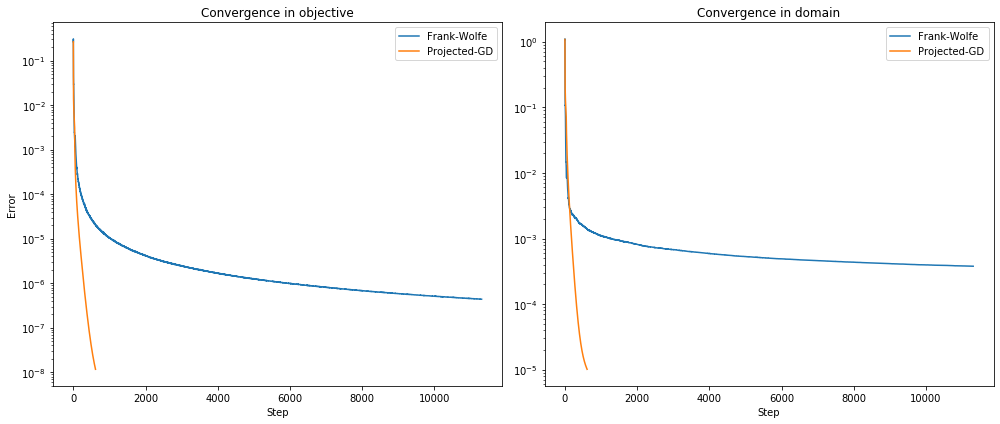

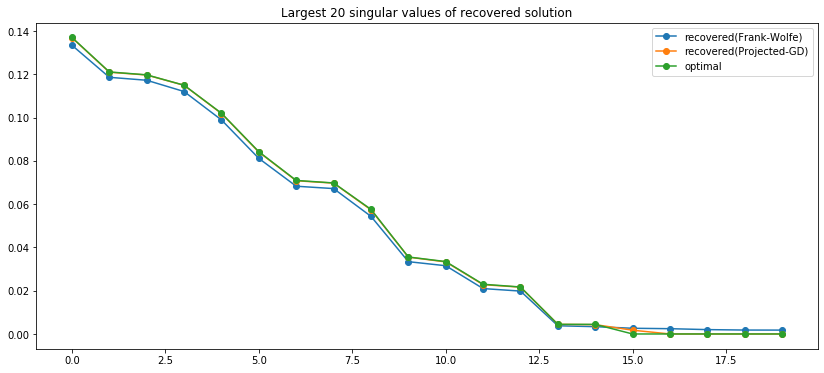

In [9]:
FW_vs_PGD(100,15,bt=False,pgd_lr=0.6)

# Conclusion

* We can obviously conclude here that FW and PGD reach the same solution.
* For time convergence speed (by number of iterations), FW is slower than PGD. (FW takes more iterations to converge.)
* For time cost to same level in objective function (comparable accuracy), FW without backtracking < PGD < FW with backtracking.
* Matrix size changes seems to have uncertain effects on training process besides larger matrix will take longer time to be completed.

# Refernce

Thanks to some course materials of EE 227C Convex Optimization and Approximation @ UC Berkeley